In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
file = '../dataset/stackoverflow_combined.csv'
df = pd.read_csv(file)

df['creation_date'] = pd.to_datetime(df['creation_date'])
df['year'] = df['creation_date'].dt.year
df['month'] = df['creation_date'].dt.month
df['year_month'] = df['creation_date'].dt.to_period('M').astype(str)

df['programming_language'] = df['programming_language'].astype(str).str.lower().str.strip()

def split_tags(tag_str):
    if isinstance(tag_str, str):
        return [tag.strip() for tag in tag_str.split(',')]
    return []

df['tags_list'] = df['tags'].apply(split_tags)

df_tags = df[['question_id', 'programming_language', 'tags_list', 'quality_score' ,'year_month', 'creation_date']]

df_exp = df_tags.explode('tags_list')
print(df_exp)

       question_id programming_language                tags_list  \
0         79810291               python                   python   
0         79810291               python  artificial-intelligence   
0         79810291               python              huggingface   
0         79810291               python                   gradio   
1         79810195               python                   python   
...            ...                  ...                      ...   
95634     78655407                  sql                 rounding   
95635     78654946                  sql                      sql   
95635     78654946                  sql               sql-server   
95635     78654946                  sql               percentage   
95635     78654946                  sql                   divide   

       quality_score year_month       creation_date  
0                0.7    2025-11 2025-11-05 15:49:00  
0                0.7    2025-11 2025-11-05 15:49:00  
0                0.7 

In [30]:
lang_tag_stats = df_exp.groupby(['programming_language', 'tags_list']).agg(['count', 'nunique'])
print(lang_tag_stats)

                                 question_id         quality_score          \
                                       count nunique         count nunique   
programming_language tags_list                                               
bash                 aix                   1       1             1       1   
                     android               1       1             1       1   
                     ansi-escape           1       1             1       1   
                     arguments             1       1             1       1   
                     arrays                1       1             1       1   
...                                      ...     ...           ...     ...   
typescript           zkp                   2       2             2       1   
                     zod                  65      65            65       6   
                     zonejs                1       1             1       1   
                     zoom-sdk              1       1            

In [23]:
lang_monthly = df_exp.groupby(['year_month', 'programming_language']).size().reset_index(name='count')
print(lang_monthly)

    year_month programming_language  count
0      2020-11                 perl    223
1      2020-11               python      9
2      2020-11                shell      5
3      2020-12                 bash      9
4      2020-12                  c++      3
..         ...                  ...    ...
933    2025-11                 rust     80
934    2025-11                scala     10
935    2025-11                  sql    106
936    2025-11                swift    147
937    2025-11           typescript    126

[938 rows x 3 columns]


In [32]:
def quality_level(score):
    if score >= 0.8:
        return 'High'
    elif score >= 0.5:
        return 'Medium'
    else:
        return 'Low'

df['quality_level'] = df['quality_score'].apply(quality_level)

quality_stats = (
    df.groupby('programming_language')['quality_score']
      .agg(['mean', 'median', 'std', 'count'])
      .sort_values('mean', ascending=False)
)

print("=== 언어별 Quality Score 통계 ===")
print(quality_stats)

=== 언어별 Quality Score 통계 ===
                          mean  median       std  count
programming_language                                   
bash                  0.939331   1.000  0.082509    124
perl                  0.929741   1.000  0.096236   3854
sql                   0.907848   0.900  0.105757   4822
shell                 0.905562   0.900  0.111120     48
r                     0.902683   1.000  0.122117   5014
rust                  0.892237   0.900  0.126520   4847
scala                 0.887870   0.900  0.124575   4526
ruby                  0.886504   0.900  0.120029   4846
c                     0.880850   0.900  0.127159   4869
html                  0.879966   0.900  0.123573   3200
c++                   0.876517   0.900  0.131708   5272
css                   0.871450   0.900  0.126957   1781
swift                 0.867215   0.900  0.133720   5044
python                0.860200   0.900  0.129995   6491
go                    0.857314   0.900  0.131360   4811
kotlin             

In [33]:
quality_ratio = (
    df.groupby('programming_language')['quality_level']
      .value_counts(normalize=True)
      .rename("ratio")
      .reset_index()
)

print("=== 언어별 High/Medium/Low 비율 ===")
print(quality_ratio)

=== 언어별 High/Medium/Low 비율 ===
   programming_language quality_level     ratio
0                  bash          High  0.943548
1                  bash        Medium  0.056452
2                     c          High  0.735059
3                     c        Medium  0.263915
4                     c           Low  0.001027
..                  ...           ...       ...
58                swift          High  0.678033
59                swift        Medium  0.320975
60                swift           Low  0.000991
61           typescript          High  0.625000
62           typescript        Medium  0.375000

[63 rows x 3 columns]


In [34]:
tag_quality = (
    df_exp.groupby('tags_list')['quality_score']
          .mean()
          .sort_values(ascending=False)
          .head(20)
)

print("=== 태그별 평균 품질 Top 20 ===")
print(tag_quality)

=== 태그별 평균 품질 Top 20 ===
tags_list
zypper                      1.0
multiton                    1.0
c#-7.3                      1.0
c#-9.0                      1.0
multiprocessing-manager     1.0
multiprocess                1.0
multiple-variable-return    1.0
multiple-select             1.0
c++-contracts               1.0
c++-experimental            1.0
multiple-constructors       1.0
multipass                   1.0
multidispatch               1.0
multicastsocket             1.0
multibyte-functions         1.0
multibyte                   1.0
multi-database              1.0
mtproto                     1.0
msxml                       1.0
c++pmr                      1.0
Name: quality_score, dtype: float64


In [35]:
lang_tag_quality = (
    df_exp.groupby(['programming_language', 'tags_list'])['quality_score']
          .agg(['mean', 'count'])
          .sort_values('mean', ascending=False)
)

print("=== 언어 × 태그 품질 통계 ===")
print(lang_tag_quality.head(20))

=== 언어 × 태그 품질 통계 ===
                                             mean  count
programming_language tags_list                          
kotlin               vungle-ads               1.0      1
html                 type-conversion          1.0      1
php                  algorithm                1.0      2
c++                  function-call-operator   1.0      1
php                  alexacrm-toolkit         1.0      1
                     aggregation-framework    1.0      1
ruby                 warden                   1.0      1
html                 tree                     1.0      1
                     treeview                 1.0      1
                     truncate                 1.0      2
php                  add-action               1.0      1
c++                  fsutil                   1.0      1
ruby                 websecurity              1.0      1
                     webserver                1.0      1
php                  activecollab             1.0      2
c++      

In [9]:
#그룹 객체 만들기3 - 언어별 난이도 통계
difficulty_group = df.groupby('programming_language')['difficulty_score'].agg(['mean', 'median', 'std', 'max', 'min'])
print("====Language Difficulty Level Statistics====")
print(difficulty_group.head(10))

====Language Difficulty Level Statistics====
                          mean  median       std    max    min
programming_language                                          
bash                  0.209968  0.2080  0.017268  0.280  0.124
c                     0.205517  0.2040  0.023933  0.449  0.001
c#                    0.201444  0.2030  0.020970  0.598  0.001
c++                   0.203018  0.2040  0.033998  0.769  0.002
css                   0.202602  0.2020  0.028881  0.600  0.001
dart                  0.204500  0.2035  0.002928  0.210  0.202
go                    0.212355  0.2070  0.036901  0.641  0.001
haskell               0.204667  0.2050  0.001528  0.206  0.203
html                  0.201010  0.2020  0.019926  0.505  0.002
java                  0.202945  0.2030  0.021661  0.547  0.001


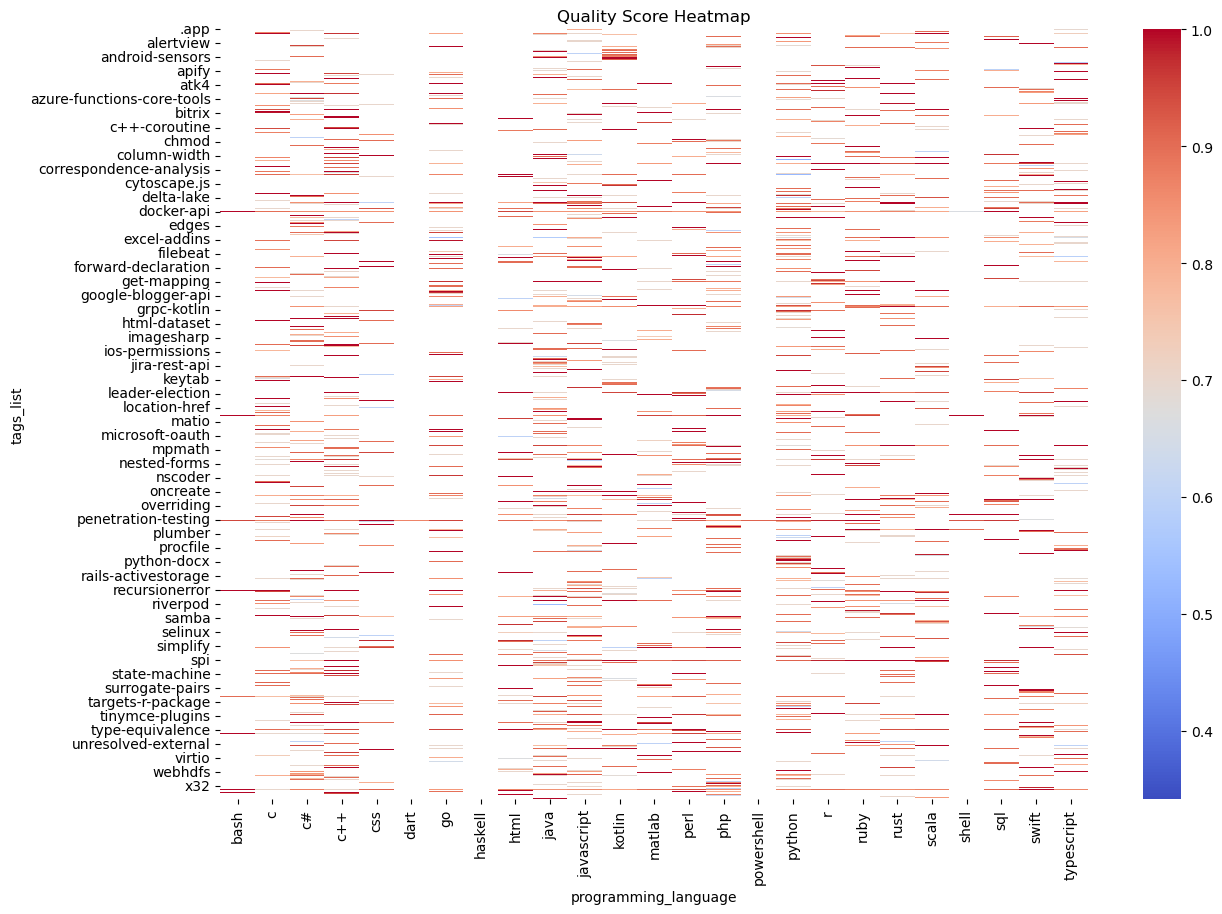

In [37]:
pivot_quality = df_exp.pivot_table(
    index='tags_list',
    columns='programming_language',
    values='quality_score',
    aggfunc='mean'
)

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_quality, cmap='coolwarm')
plt.title("Quality Score Heatmap")
plt.show()

C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\CBNU_BML\AppData\Local\Temp\ipykernel_16804\4269990197.py:16: UserWarning: Glyph 51656 (\N{HANGUL SYLLAB

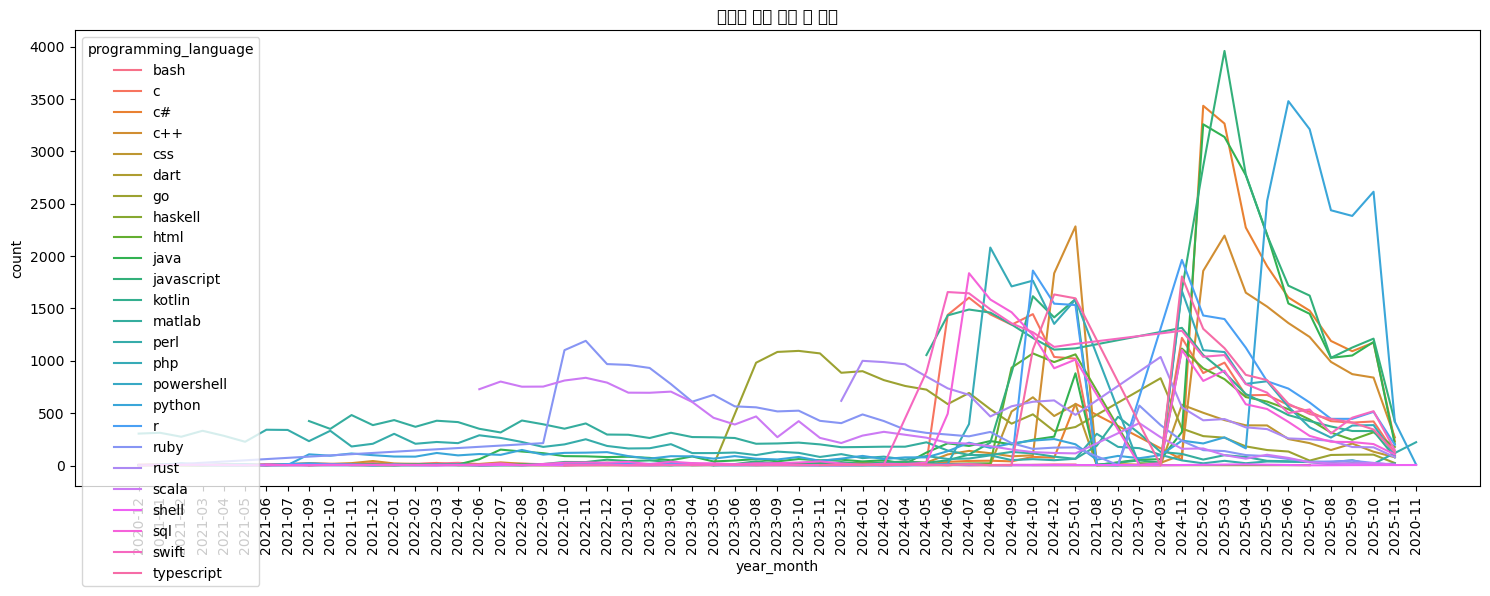

In [38]:
lang_monthly = (
    df_exp.groupby(['programming_language', 'year_month'])
          .size()
          .reset_index(name='count')
)

plt.figure(figsize=(15, 6))
sns.lineplot(
    data=lang_monthly,
    x='year_month',
    y='count',
    hue='programming_language'
)
plt.xticks(rotation=90)
plt.title("언어별 월간 질문 수 변화")
plt.tight_layout()
plt.show()

Accuracy: 0.7099304502431627
              precision    recall  f1-score   support

        High       0.74      0.92      0.82     13564
         Low       0.00      0.00      0.00         9
      Medium       0.50      0.20      0.29      5550

    accuracy                           0.71     19123
   macro avg       0.41      0.37      0.37     19123
weighted avg       0.67      0.71      0.66     19123



c:\Users\CBNU_BML\miniconda3\envs\jupyter_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CBNU_BML\miniconda3\envs\jupyter_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\CBNU_BML\miniconda3\envs\jupyter_venv\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

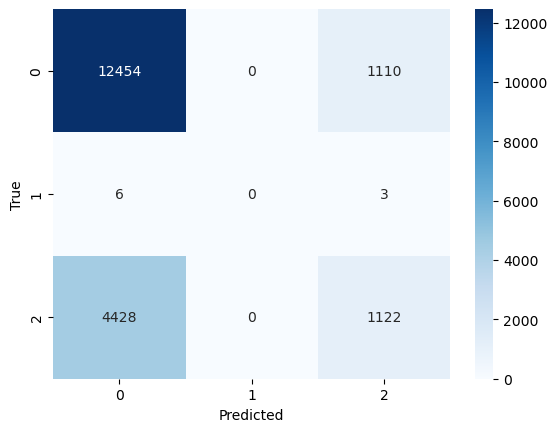

High


In [43]:
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

df_text = df[['body', 'quality_level']].dropna()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'<code>.*?</code>', '', text, flags=re.DOTALL)
    text = re.sub(r'`.*?`', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df_text['clean_body'] = df_text['body'].apply(clean_text)

X_train, X_test, y_train, y_test = train_test_split(
    df_text['clean_body'], df_text['quality_level'],
    test_size=0.2, random_state=42
)

vectorizer = TfidfVectorizer(max_features=8000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

clf = LogisticRegression(max_iter=500)
clf.fit(X_train_vec, y_train)
pred = clf.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

def predict_quality(question_text):
    text = clean_text(question_text)
    vec = vectorizer.transform([text])
    pred = clf.predict(vec)[0]
    return pred

print(predict_quality("I attempted to use pandas.merge on two DataFrames, but when specifying `on='id'`, I get a KeyError. What are the possible causes? Code and sample data included."))